In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import json
from datetime import datetime as dt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from math import radians # to convert latitude/longitude

import plotly.io as pio
pio.renderers.default = 'iframe'

# Boston Airbnb Dataset
https://www.kaggle.com/datasets/airbnb/boston?resource=download

Three questions/topics to explore:
- How does **geography** inlfuence Airbnb prices in Boston?
    - What areas/zip codes/neighborhoods are more expensive than others?
- How do **property characteristics** influence Airbnb prices in Boston?
    - Number of bathrooms, bedrooms, beds, square footage, reviews, etc.
- How does **time (seasonality)** influence Airbnb prices in Boston?
    - Period of the week (days), period of the month (weeks), period of the year (months)?
    - We only have about 2 years of data to work with, but we'll see what comes out.

In [2]:
def get_columns_and_types(df):
    """
    Loop over the dtypes of the columns of a dataframe, and return a dictionary of lists identifying which are ints, floats and objects.
    """
    print(f'Types detected: {", ".join([str(i) for i in df.dtypes.unique()])}')
    return {
        'int': [label for label, dtype in df.dtypes.items() if dtype in [int, np.int64]],
        'float': [label for label, dtype in df.dtypes.items() if dtype in [float, np.float64]],
        'object': [label for label, dtype in df.dtypes.items() if dtype in ['O', 'object']],
    }


def convert_dollars_to_float(s, pattern=r"\$|,"):
    """
    Convert money-like strings to floats.
    """
    if type(s) is str and re.match(pattern, s):
        # if the input is a str containing '$' and/or ',' try to remove those chars and covert the result to a float
        # if this fails, then there is likely text mixed in (like "$195 this week only!")
        try:
            return float(re.sub(pattern, repl='', string=s))
        except:
            return s
    else:
        # otherwise just return the input
        return s


def estimate_y_from_X(data, y_label, X_labels, train_size=0.6, random_state=42, add_constant=False):
    """
    Run a linear regression on data using y_label as the dependent variable and X_labels as the independent variable(s): y_label ~ X_labels
    A constant can be optionally added, but note that the r2 test may give misleading results when a constant is included.
    """
    if type(X_labels) not in [list, tuple]:
        X_labels = [X_labels] # in case we pass a scalar
        
    # we know that we have data for 'price' in all observations, but not for 'monthly_price' or 'weekly_price'
    # drop the nans, create a train/test split, build a model and estimate the monthly, then use the model to fill the missing values in the dataset
    reg_data = data[X_labels + [y_label]].dropna()
    y = reg_data[y_label]
    X = reg_data[X_labels]
    if add_constant:
        X = sm.add_constant(reg_data[X_labels])
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

    print(f'Estimating {y_label}~1+{"+".join(X_labels)}')
    m = sm.OLS(exog=X_train, endog=y_train).fit()
    
    print(f'... Train fit: {r2_score(y_true=y_train, y_pred=m.predict(exog=X_train)):.2f}')
    print(f'... Test fit: {r2_score(y_true=y_test, y_pred=m.predict(exog=X_test)):.2f}')
    
    print(f'... Filling NaNs in {y_label} with estimated data')
    missing = data[y_label][data[y_label].isnull()].index
    if add_constant:
        data.loc[missing, y_label] = m.predict(exog=sm.add_constant(data[data[y_label].isnull()][X_labels]))
    else:
        data.loc[missing, y_label] = m.predict(exog=data[data[y_label].isnull()][X_labels])
    
    return {
        'filled_data': data,
        'model': m,
        'X_train': X_train, 
        'X_test': X_test, 
        'y_train': y_train,
        'y_test': y_test,
    }


def convert_percentages_to_float(s):
    """
    Take in a value, and if it is a string ending with a percent side, strip the percent sign and return a float. 
    If the conversion fails, return the original value.
    """
    if type(s) is str and s.endswith('%'):
        try:
            return float(s.strip('%'))
        except:
            return s
    else:
        return s

def convert_string_date_to_dt(s):
    """
    Take in a value, and if it is a string that looks like a date in YYYY-MM-DD format, convert it to a datetime object.
    If the conversion fails, return the original value.
    """
    try:
        return dt.strptime(s, '%Y-%m-%d')
    except:
        return s

        
def get_cleaned_zipcodes(data):
    """
    Scan over the values of 'zipcodes' in the data, and isolate those that are 5 characters long, with other values
    return as NaN. This dataset is pretty clean with zips, but there's at least 1 entry where the zip is more than 10 digits.
    Store the cleaned values as 'zipcode_cleaned'. Note that if the 'zipcode_cleaned' field is aready in data, it will be dropped 
    and recalculated.

    The 'zipcode_cleaned' field - including the nans - will be used later to feed into a classifier (to get estimates for the nans 
    based on latitude and longitude).
    """
    if 'zipcode_cleaned' in data:
        data = data.drop('zipcode_cleaned', axis=1)

    new_zipcodes = []
    for k, v in data['zipcode'].items():
        if pd.isnull(v) or type(v) is str and len(v) != 5:
            new_zipcodes.append(np.nan)
        else:
            new_zipcodes.append(str(v))
    data = pd.concat([
        data,
        pd.Series(index=data.index, data=new_zipcodes).to_frame('zipcode_cleaned').astype('Int64'),
    ], axis=1)
    return data
    

def classify_y_based_on_X(data, y_label, X_labels, train_size=0.6, random_state=42):
    """
    Wrapped for a K nearest neighbor classifier, that will estimate categories contained in y_label column of data, 
    using the variables contained in X labels columns of data.
    """

    if type(X_labels) is str:
        X_labels = [X_labels]
    
    knn_data = data[[y_label] + X_labels].dropna()
    y = knn_data[y_label]
    X = knn_data[X_labels]    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
    
    print(f'Estimating {y_label} labels from {"+".join(X_labels)}')
    m_knn = KNeighborsClassifier()
    m_knn.fit(X_train, y_train)
    
    print(f'... Train fit: {m_knn.score(X_train, y_train):.2f}')
    print(f'... Test fit: {m_knn.score(X_test, y_test):.2f}')
    
    print(f'... Filling NaNs in {y_label} with estimated data')
    missing = data[y_label][data[y_label].isnull()].index
    data.loc[missing, y_label] = m_knn.predict(data[data[y_label].isnull()][X_labels])
    
    return {
        'filled_data': data,
        'model': m_knn,
        'X_train': X_train, 
        'X_test': X_test, 
        'y_train': y_train,
        'y_test': y_test,
    }


# First, load and clean the data

In [3]:
boston_listings = pd.read_csv('./data/airbnb_boston/listings.csv', index_col='id')
boston_calendar = pd.read_csv('./data/airbnb_boston/calendar.csv')
boston_reviews = pd.read_csv('./data/airbnb_boston/reviews.csv')

boston_listings = boston_listings.map(convert_dollars_to_float).map(convert_percentages_to_float).map(convert_string_date_to_dt)
boston_calendar = boston_calendar.apply(convert_dollars_to_float).map(convert_percentages_to_float).map(convert_string_date_to_dt)
boston_reviews = boston_reviews.apply(convert_dollars_to_float).map(convert_percentages_to_float).map(convert_string_date_to_dt)

# estimate missing monthly_price/weekly_price fields using regression (based on price field)
boston_listings = estimate_y_from_X(data=boston_listings, y_label='monthly_price', X_labels='price')['filled_data']
boston_listings = estimate_y_from_X(data=boston_listings, y_label='weekly_price', X_labels='price')['filled_data']

# estimate missing zip codes using KNN classification (based on latitude and longitude)
boston_listings = classify_y_based_on_X(
    data=get_cleaned_zipcodes(boston_listings), y_label='zipcode_cleaned', X_labels=['latitude', 'longitude'])['filled_data']

Estimating monthly_price~1+price
... Train fit: 0.75
... Test fit: 0.70
... Filling NaNs in monthly_price with estimated data
Estimating weekly_price~1+price
... Train fit: 0.86
... Test fit: 0.81
... Filling NaNs in weekly_price with estimated data
Estimating zipcode_cleaned labels from latitude+longitude
... Train fit: 0.93
... Test fit: 0.90
... Filling NaNs in zipcode_cleaned with estimated data


In [4]:
# identify column types
boston_listing_col_types = get_columns_and_types(boston_listings)
boston_calendar_col_types = get_columns_and_types(boston_calendar)
boston_review_col_types = get_columns_and_types(boston_reviews)
# boston_listing_col_types

Types detected: object, int64, datetime64[ns], float64, Int64
Types detected: int64, datetime64[ns], object
Types detected: int64, datetime64[ns], object


# Question 1: How does geography influence Airbnb rental prices?

## Add a choropleth (geographical map) and overlay the listings prices from the dataset.
- Thank you for the geojson data: https://github.com/codeforgermany/click_that_hood/blob/main/public/data/boston.geojson?short_path=46589b4
- Use log scale for the prices (so the colorbar isn't too compressed) - or change the scale of the colorbar.

A quick visual inspection of the map allow us to see more expensive listings tend to northward, and in the following neighborhoods (in no particular order):
- West End, North End, South End, Downtown, Leather District, Chinatown, Leather District, South Boston Waterfront, Fenway.

- What if we run a regression-type model of price on latitude+longitude?

In [5]:
# geoplot of neighborhoods with listings overlaid
with open('./data/airbnb_boston/boston.geojson', 'r') as f:
    geojson = json.load(f)
    
plot_data = boston_listings[['latitude', 'longitude', 'zipcode_cleaned', 'price']].dropna()
plot_data['log_price'] = plot_data['price'].apply(np.log)

fig = px.choropleth(
    data_frame={'name': [i['properties']['name'] for i in geojson['features']]}, 
    geojson=geojson, 
    locations='name', 
    featureidkey="properties.name",
    title='Boston Neighborhoods and Airbnb Prices<br>Colorbar is Log Scale',
)
fig.update_geos(fitbounds="locations", visible=False) 
fig.add_trace(
    px.scatter_geo(
        data_frame=plot_data, 
        lat='latitude', 
        lon='longitude', 
        color='log_price',
        hover_data={
            'latitude': ':.2f', 
            'longitude': ':.2f', 
            'price': ':.2f', 
            'log_price': ':.2f',
        },
    ).data[0])

# relabel the colorbar (as showing log values is confusing)
fig.update_coloraxes(colorbar={
    'title': 'Price',
    'tickvals': plot_data['log_price'].quantile([0.01, 0.999]).values,
    'ticktext': ['Cheaper', 'Pricier'],
})
fig.update_layout(showlegend=False)

fig.show()

pio.write_image(fig, 'prices_and_neighborhoods.png') 

In [23]:
pd.concat([
    boston_listings[['price', 'neighbourhood_cleansed']].groupby('neighbourhood_cleansed').mean().squeeze().to_frame('Mean Price'),
    boston_listings[['price', 'neighbourhood_cleansed']].groupby('neighbourhood_cleansed').median().squeeze().to_frame('Median Price'),
], axis=1).sort_values(by='Median Price').style.format('${:.0f}').set_caption('Mean and Median Price by Neighborhood<br>Sorted by Median')

,Mean Price,Median Price
neighbourhood_cleansed,,
Hyde Park,$87,$58
Mattapan,$75,$67
Dorchester,$92,$72
Roslindale,$98,$76
Longwood Medical Area,$138,$84
Allston,$112,$85
West Roxbury,$107,$85
Mission Hill,$122,$90
Brighton,$119,$90


# Let's look at how well a regression can fit price on latitude and longitude
- This gives a very poor fit, even on the training set. Why?
    - It could be that latitude and longtide - which reflect locations on a sphere (the Earth) do not align well with 2d locations on a map.
    - Therefore, the link betweeb price and lat/lon may not be linear, which means regression is not the right tool.
    - Let's keep exploring.

In [7]:
reg_price_on_lat_lon = estimate_y_from_X(
    data=boston_listings,
    y_label='price',
    X_labels=['latitude', 'longitude'],
    train_size=0.6,
    random_state=42,
    add_constant=False,
)

Estimating price~1+latitude+longitude
... Train fit: 0.06
... Test fit: 0.04
... Filling NaNs in price with estimated data


<Axes: xlabel='y_train', ylabel='y_fitted'>

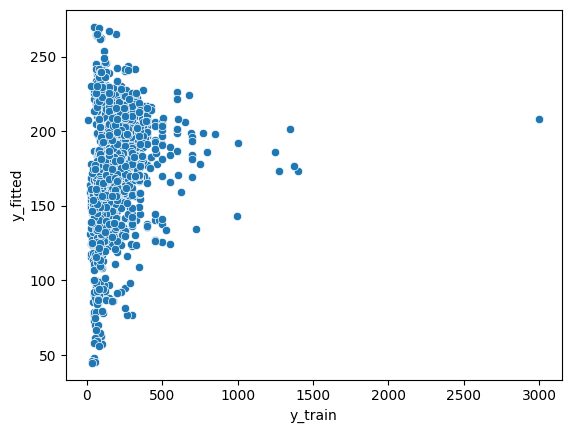

In [8]:
sns.scatterplot(
    data=pd.concat({
        'y_train': reg_price_on_lat_lon['y_train'],
        'y_fitted': reg_price_on_lat_lon['model'].fittedvalues,
    }, axis=1),
    x='y_train',
    y='y_fitted',
)

# Question 2: How do characteristics influence Airbnb listing prices?
- Here, we can structure a regression on categorical variables against price.
    - But we should ensure that numeric categoricals - like number of bedrooms - appear here!
    - Quantitative variables - like square footage - should also appear!
- Remember to create dummies from the categoricals.
- From a manual review of categories, these look like they may be informative (not free text, not arbitrary values, etc)
    - room_type
- TODO: clean up AMENITIES

In [9]:
boston_listings['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [24]:
boston_listing_col_types['int']

['scrape_id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'accommodates',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'calculated_host_listings_count']

In [25]:
ignore = [
    'name', 'summary', 'space', 'description', 'neighborhood_overview', 'host_verifications', 'neighbourhood', 'host_about', 'notes',
    'transit', 'host_location', 'access', 'host_about', 'interaction', 'zipcode', 'smart_location', 'house_rules',
    'neighbourhood_cleansed', 'city', 'street', 'host_neighbourhood', 'host_name',
]

unique_characteristics = {}
for i in boston_listing_col_types['object'] + boston_listing_col_types['int']:
    if i in ignore or '_url' in i:
        continue
    unique_values = boston_listings[i].dropna().unique()
    if len(unique_values) > 1:
        unique_characteristics[i] = unique_values

In [27]:
boston_listing_col_types['float']

['host_response_rate',
 'host_acceptance_rate',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'extra_people',
 'has_availability',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'jurisdiction_names',
 'reviews_per_month']

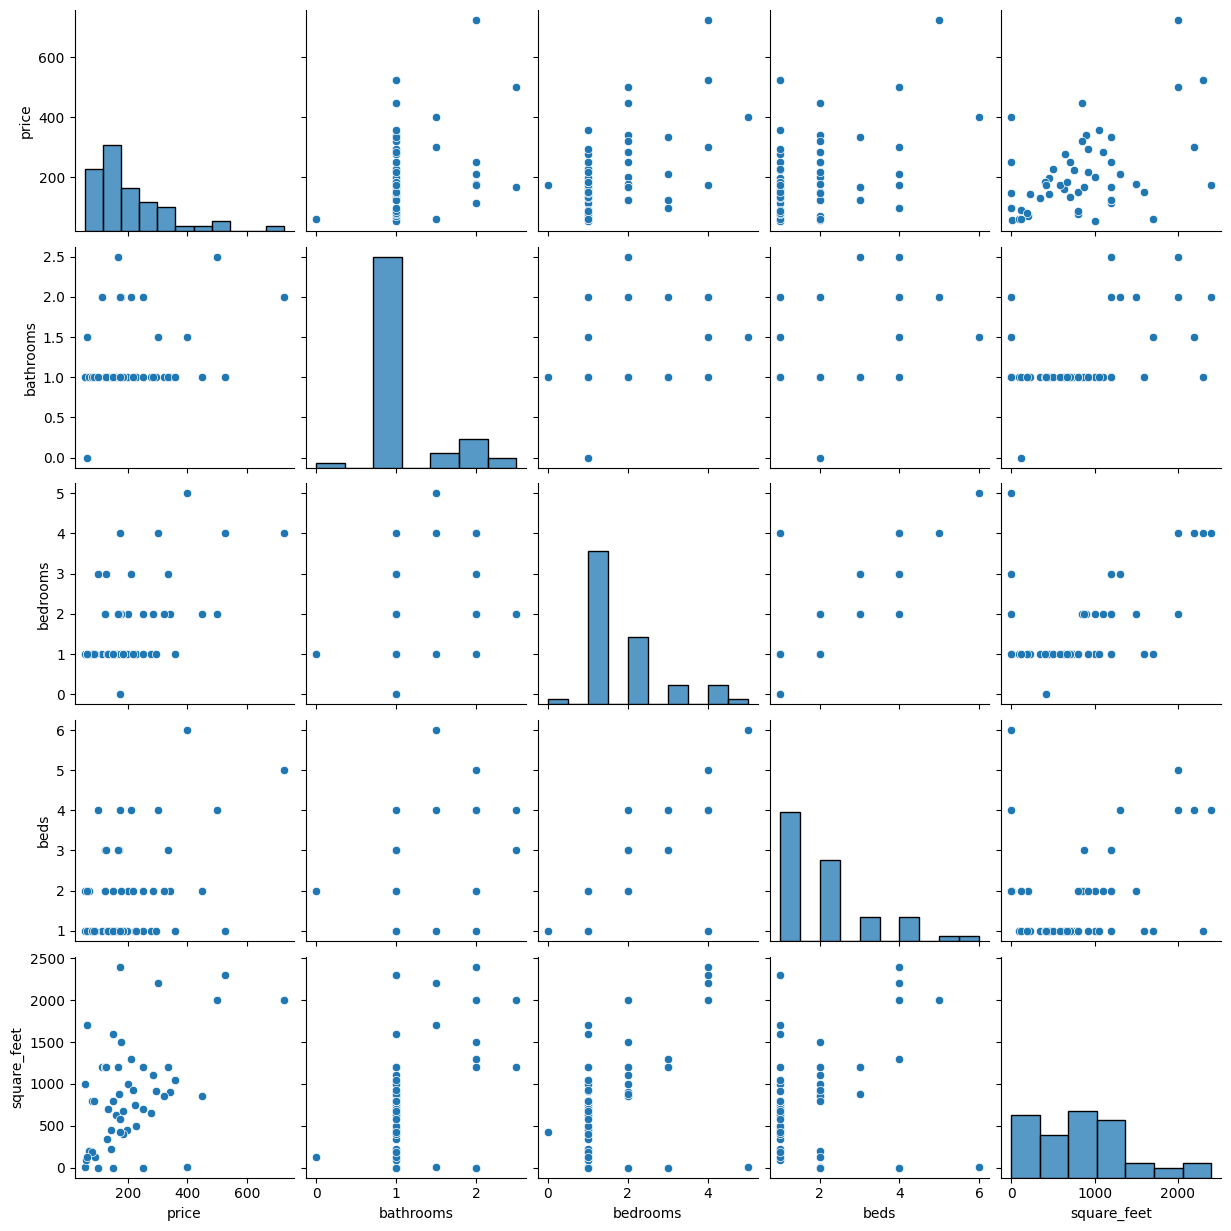

In [32]:
sns.pairplot(
    data=boston_listings[['price', 'bathrooms', 'bedrooms', 'beds', 'square_feet']].dropna()
)

<Axes: xlabel='square_feet', ylabel='price'>

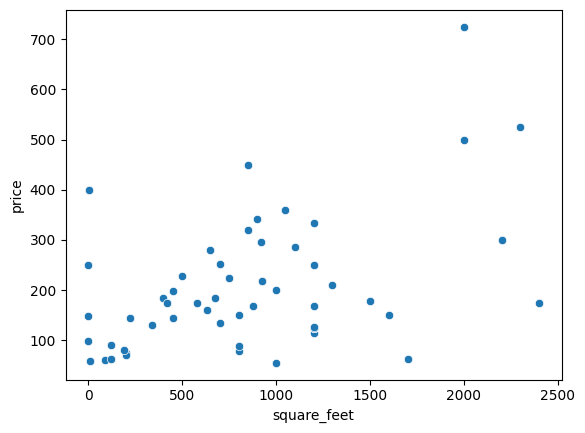

In [13]:
sns.scatterplot(
    data=boston_listings[['price', 'square_feet']].dropna(),
    x='square_feet', y='price')

In [12]:
boston_listings[boston_listing_col_types['object']].iloc[-1]

listing_url                                     https://www.airbnb.com/rooms/14504422
name                                               (K1) Private Room near Harvard/MIT
summary                             My place is close to My home is a warm and fri...
space                               To ensure a smooth check in: 1. You MUST have ...
description                         My place is close to My home is a warm and fri...
experiences_offered                                                              none
neighborhood_overview                                                             NaN
notes                                                                             NaN
transit                                                                           NaN
access                                                                            NaN
interaction                                                                       NaN
house_rules                                           

In [95]:
# sns.pairplot(
#     boston_listings[boston_listing_col_types['float']].sort_index().dropna(how='all', axis=1) \
#         .drop(['latitude', 'longitude', 'weekly_price', 'monthly_price'], axis=1)
# )

# Question 3: How does time influence Airbnb listing prices?
- Day of week.
- Week of month.
- Month of year.

In [91]:
# convert price column to a float, assuming format of $#.#
boston_calendar.price = [float(i.replace('$', '').replace(',', '')) if type(i) is str else i for i in boston_calendar.price]

# concert date to a datetime object
boston_calendar.date = [pd.Timestamp(i) if type(i) is str else i for i in boston_calendar.date]

# add a month, year columns for seasonality analysis
day_map = {0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
boston_calendar['weekday'] = [i.weekday() for i in boston_calendar.date]
boston_calendar['month'] = [i.month for i in boston_calendar.date]
boston_calendar['year'] = [i.year for i in boston_calendar.date]

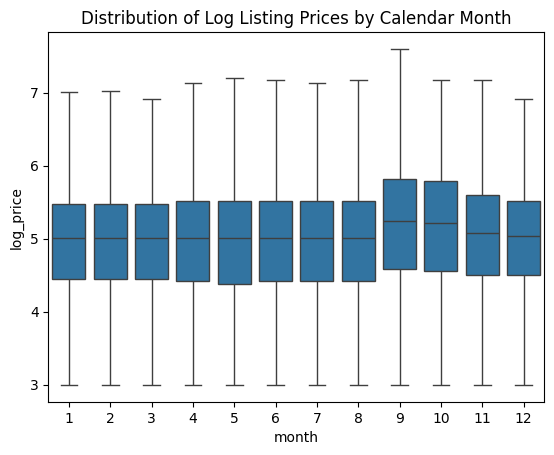

In [92]:
ax = sns.boxplot(
    data=(
        boston_calendar.assign(log_price=lambda x: np.log(x['price'])).dropna()
    ),
    x='month',
    y='log_price',
    showfliers=False,
    whis=1.5,
)
ax.set_title("Distribution of Log Listing Prices by Calendar Month");

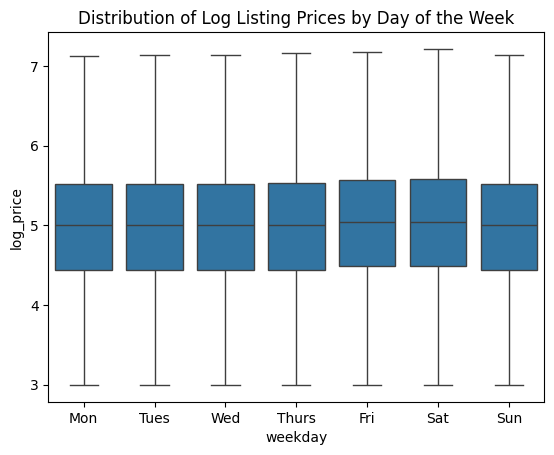

In [94]:
ax = sns.boxplot(
    data=(
        boston_calendar.assign(log_price=lambda x: np.log(x['price'])).dropna()
    ),
    x='weekday',
    y='log_price',
    showfliers=False,
    whis=1.5,
)
ax.set_title("Distribution of Log Listing Prices by Day of the Week");
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(day_map[i] for i in ax.get_xticks());